In [198]:
%matplotlib inline

import os
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import datetime

In [8]:
# ga_data=pd.read_csv("train.csv")
# ga_data

In [9]:
#def load_df(csv_path='train.csv', nrows=None):
json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']

ga_data = pd.read_csv('../GACustomerRevenue/train.csv', 
                 converters={column: json.loads for column in json_columns}, 
                 dtype={'fullVisitorId': 'str'},
                     )
                 #nrows=100)
ga_data.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",1131660440785968503,"{'continent': 'Asia', 'subContinent': 'Western...",1131660440785968503_1472830385,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472830385,1,1472830385
1,Organic Search,20160902,"{'browser': 'Firefox', 'browserVersion': 'not ...",377306020877927890,"{'continent': 'Oceania', 'subContinent': 'Aust...",377306020877927890_1472880147,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472880147,1,1472880147
2,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",3895546263509774583,"{'continent': 'Europe', 'subContinent': 'South...",3895546263509774583_1472865386,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472865386,1,1472865386
3,Organic Search,20160902,"{'browser': 'UC Browser', 'browserVersion': 'n...",4763447161404445595,"{'continent': 'Asia', 'subContinent': 'Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472881213,1,1472881213
4,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",27294437909732085,"{'continent': 'Europe', 'subContinent': 'North...",27294437909732085_1472822600,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472822600,2,1472822600


In [10]:
for column in json_columns:
    column_as_df = pd.json_normalize(ga_data[column])
    column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
    ga_data = ga_data.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
ga_data

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Social,20170104,5123779100307500332,5123779100307500332_1483554750,Not Socially Engaged,1483554750,1,1483554750,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903649,Social,20170104,7231728964973959842,7231728964973959842_1483543798,Not Socially Engaged,1483543798,1,1483543798,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903650,Social,20170104,5744576632396406899,5744576632396406899_1483526434,Not Socially Engaged,1483526434,1,1483526434,Android Webview,not available in demo dataset,...,not available in demo dataset,NaN,/yt/about/ko/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903651,Social,20170104,2709355455991750775,2709355455991750775_1483592857,Not Socially Engaged,1483592857,1,1483592864,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,/l.php,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
ga_data.shape

(903653, 55)

In [12]:
ga_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [13]:
print("Channel Grouping:", ga_data.channelGrouping.unique().tolist())
print("Social Engagement Type:", ga_data.socialEngagementType.unique().tolist())
print("Number of unique IDs:",len(ga_data.visitId.unique()))
print("Browser used:", ga_data["device.browser"].unique())

Channel Grouping: ['Organic Search', 'Referral', 'Paid Search', 'Affiliates', 'Direct', 'Display', 'Social', '(Other)']
Social Engagement Type: ['Not Socially Engaged']
Number of unique IDs: 886303
Browser used: ['Chrome' 'Firefox' 'UC Browser' 'Internet Explorer' 'Safari' 'Edge'
 'Opera Mini' 'Opera' 'BlackBerry' 'Safari (in-app)' 'Coc Coc'
 'Mozilla Compatible Agent' 'ADM' 'MRCHROME' 'Amazon Silk' 'YaBrowser'
 'Android Webview' 'Puffin' 'Nokia Browser' 'Maxthon' 'Nintendo Browser'
 'Android Browser' 'Lunascape' 'IE with Chrome Frame' 'ThumbSniper'
 'LYF_LS_4002_12' 'Mozilla' 'osee2unifiedRelease' 'NokiaE52-1' 'Iron'
 '[Use default User-agent string] LIVRENPOCHE' '(not set)'
 'LYF_LS_4002_11' 'M5' 'Android Runtime' 'Apple-iPhone7C2' 'SeaMonkey'
 'Konqueror' 'Seznam' 'Changa 99695759' 'no-ua' 'MQQBrowser' 'Nichrome'
 'HTC802t_TD' 'DASH_JR_3G' 'DoCoMo' 'subjectAgent: NoticiasBoom' 'YE'
 'User Agent' '0' 'Hisense M20-M_LTE' 'Reddit' 'TCL P500M' 'CSM Click']


In [14]:
print("Browser used:", ga_data["geoNetwork.country"].unique())

Browser used: ['Turkey' 'Australia' 'Spain' 'Indonesia' 'United Kingdom' 'Italy'
 'Pakistan' 'Austria' 'Netherlands' 'India' 'France' 'Brazil' 'China'
 'Singapore' 'Argentina' 'Poland' 'Germany' 'Canada' 'Thailand' 'Hungary'
 'Malaysia' 'Denmark' 'Taiwan' 'Russia' 'Nigeria' 'Belgium' 'South Korea'
 'Chile' 'Ireland' 'Philippines' 'Greece' 'Mexico' 'Montenegro'
 'United States' 'Bangladesh' 'Japan' 'Slovenia' 'Czechia' 'Sweden'
 'United Arab Emirates' 'Switzerland' 'Portugal' 'Peru' 'Hong Kong'
 'Vietnam' 'Sri Lanka' 'Serbia' 'Norway' 'Romania' 'Kenya' 'Ukraine'
 'Israel' 'Slovakia' '(not set)' 'Lithuania' 'Puerto Rico'
 'Bosnia & Herzegovina' 'Croatia' 'South Africa' 'Paraguay' 'Botswana'
 'Colombia' 'Uruguay' 'Algeria' 'Finland' 'Guatemala' 'Egypt' 'Malta'
 'Bulgaria' 'New Zealand' 'Kuwait' 'Uzbekistan' 'Saudi Arabia' 'Cyprus'
 'Estonia' 'Côte d’Ivoire' 'Morocco' 'Tunisia' 'Venezuela'
 'Dominican Republic' 'Senegal' 'Cape Verde' 'Costa Rica' 'Kazakhstan'
 'Macedonia (FYROM)' 'Oman' 'L

## Percentage of NAN values in each column

In [41]:
ga_data.isna().sum()/len(ga_data) * 100

channelGrouping                                       0.000000
date                                                  0.000000
fullVisitorId                                         0.000000
sessionId                                             0.000000
socialEngagementType                                  0.000000
visitId                                               0.000000
visitNumber                                           0.000000
visitStartTime                                        0.000000
device.browser                                        0.000000
device.browserVersion                                 0.000000
device.browserSize                                    0.000000
device.operatingSystem                                0.000000
device.operatingSystemVersion                         0.000000
device.isMobile                                       0.000000
device.mobileDeviceBranding                           0.000000
device.mobileDeviceModel                              0

In [218]:
unique_value_cols = []
columns = ga_data.columns
for column in columns:
     if ga_data[column].nunique() == 1: unique_value_cols.append(column)
print('Number of columns with constant values:',len(unique_value_cols))
unique_value_cols

Number of columns with constant values: 24


['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']

In [220]:
ga_data[['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']]

,socialEngagementType,device.browserVersion,device.browserSize,device.operatingSystemVersion,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,...,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.bounces,totals.newVisits,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,not available in demo dataset,NaN,NaN,NaN
1,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,not available in demo dataset,NaN,NaN,NaN
2,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,not available in demo dataset,NaN,NaN,NaN
3,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,not available in demo dataset,NaN,NaN,NaN
4,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,NaN,not available in demo dataset,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,NaN,1,not available in demo dataset,NaN,NaN,NaN
903649,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,NaN,1,not available in demo dataset,NaN,NaN,NaN
903650,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not a

Remove columns with high NAN value percentage and unique data in all columns which is not relevent.

In [221]:
ga_data_clean = ga_data.drop(columns=
                             ['socialEngagementType','device.browserVersion','device.browserSize','device.operatingSystemVersion',
                              'device.mobileDeviceBranding','device.mobileDeviceModel','device.mobileInputSelector',
                              'device.mobileDeviceInfo','device.mobileDeviceMarketingName','device.flashVersion',
                              'device.language','device.screenColors','device.screenResolution',
                              'geoNetwork.cityId','geoNetwork.latitude','geoNetwork.longitude',
                              'geoNetwork.networkLocation','trafficSource.adwordsClickInfo.criteriaParameters','trafficSource.isTrueDirect',
                              'trafficSource.referralPath','trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.slot',
                              'trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.isVideoAd',
                              'trafficSource.adContent','trafficSource.campaignCode'
                             ])

In [222]:
ga_data_clean

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,...,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,...,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,...,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,Linux,False,...,1,1,1,1,1,NaN,(not set),google,organic,google + online
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,Android,True,...,1,1,1,1,NaN,NaN,(not set),google,organic,(not provided)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Social,20170104,5123779100307500332,5123779100307500332_1483554750,1483554750,1,1483554750,Chrome,Windows,False,...,1,17,15,NaN,1,NaN,(not set),youtube.com,referral,NaN
903649,Social,20170104,7231728964973959842,7231728964973959842_1483543798,1483543798,1,1483543798,Chrome,Android,True,...,1,18,13,NaN,1,NaN,(not set),youtube.com,referral,NaN
903650,Social,20170104,5744576632396406899,5744576632396406899_1483526434,1483526434,1,1483526434,Android Webview,Android,True,...,1,24,21,NaN,1,NaN,(not set),youtube.com,referral,NaN
903651,Social,20170104,2709355455991750775,2709355455991750775_1483592857,1483592857,1,1483592864,Chrome,Windows,False,...,1,24,22,NaN,1,NaN,(not set),facebook.com,referral,NaN


In [223]:
ga_data_clean.shape

(903653, 28)

In [224]:
ga_data_clean.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.visits', 'totals.hits',
       'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium',
       'trafficSource.keyword'],
      dtype='object')

In [225]:
ga_data_clean.fillna(0, inplace=True)
ga_data_clean['totals.transactionRevenue'] = ga_data_clean['totals.transactionRevenue'].astype('float')
ga_data_clean['totals.visits'] = ga_data_clean['totals.visits'].astype('int32')
ga_data_clean

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,...,1,1,1,1,1,0.0,(not set),google,organic,(not provided)
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,...,1,1,1,1,1,0.0,(not set),google,organic,(not provided)
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,...,1,1,1,1,1,0.0,(not set),google,organic,(not provided)
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,Linux,False,...,1,1,1,1,1,0.0,(not set),google,organic,google + online
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,Android,True,...,1,1,1,1,0,0.0,(not set),google,organic,(not provided)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Social,20170104,5123779100307500332,5123779100307500332_1483554750,1483554750,1,1483554750,Chrome,Windows,False,...,1,17,15,0,1,0.0,(not set),youtube.com,referral,0
903649,Social,20170104,7231728964973959842,7231728964973959842_1483543798,1483543798,1,1483543798,Chrome,Android,True,...,1,18,13,0,1,0.0,(not set),youtube.com,referral,0
903650,Social,20170104,5744576632396406899,5744576632396406899_1483526434,1483526434,1,1483526434,Android Webview,Android,True,...,1,24,21,0,1,0.0,(not set),youtube.com,referral,0
903651,Social,20170104,2709355455991750775,2709355455991750775_1483592857,1483592857,1,1483592864,Chrome,Windows,False,...,1,24,22,0,1,0.0,(not set),facebook.com,referral,0


In [226]:
continent_totals_df = ga_data_clean.groupby(by=['geoNetwork.continent']).agg(
                        total_visits = ('totals.visits', sum),
                        mean_revenue = ('totals.transactionRevenue', np.mean))\
                        .reset_index()\
                        .rename(columns= {'geoNetwork.continent':'continent'})\
                        .sort_values(by=['mean_revenue', 'total_visits'], ascending=False)
continent_totals_df.drop(continent_totals_df.loc[continent_totals_df['continent']=='(not set)'].index, inplace=True)
continent_totals_df

,continent,total_visits,mean_revenue
2,Americas,450377,3.340916e+06
1,Africa,14745,5.892004e+05
5,Oceania,15054,1.191198e+05
3,Asia,223698,7.779167e+04
4,Europe,198311,3.402247e+04


In [227]:
subcontinent_totals_df = ga_data_clean.groupby(by=['geoNetwork.subContinent']).agg(
                        total_visits = ('totals.visits', sum),
                        mean_revenue = ('totals.transactionRevenue', np.mean))\
                        .reset_index()\
                        .rename(columns= {'geoNetwork.subContinent':'subcontinent'})\
                        .sort_values(by=['mean_revenue', 'total_visits'], ascending=False)
subcontinent_totals_df.drop(subcontinent_totals_df.loc[subcontinent_totals_df['subcontinent']=='(not set)'].index, inplace=True)
subcontinent_totals_df

,subcontinent,total_visits,mean_revenue
12,Northern America,390657,3.801967e+06
5,Eastern Africa,1927,2.734146e+06
20,Western Africa,2573,1.283482e+06
2,Caribbean,2406,6.498545e+05
15,South America,41731,3.819058e+05
6,Eastern Asia,46919,2.360498e+05
3,Central America,15583,1.222839e+05
1,Australasia,14893,1.204076e+05
16,Southeast Asia,77800,4.827751e+04
22,Western Europe,59114,4.808235e+04


In [228]:
country_totals_df = ga_data_clean.groupby(by=['geoNetwork.country']).agg(
                        total_visits = ('totals.visits', sum),
                        mean_revenue = ('totals.transactionRevenue', np.mean))\
                        .reset_index()\
                        .rename(columns= {'geoNetwork.country':'country'})\
                        .sort_values(by=['mean_revenue', 'total_visits'], ascending=False)
country_totals_df.drop(country_totals_df.loc[country_totals_df['country']=='(not set)'].index, inplace=True)
country_totals_df

,country,total_visits,mean_revenue
7,Anguilla,1,1.099000e+07
51,Curaçao,30,6.877667e+06
106,Kenya,771,6.833593e+06
216,Venezuela,2132,6.273405e+06
185,St. Lucia,24,4.842083e+06
...,...,...,...
183,St. Barthélemy,1,0.000000e+00
186,St. Martin,1,0.000000e+00
187,St. Pierre & Miquelon,1,0.000000e+00
195,São Tomé & Príncipe,1,0.000000e+00


In [229]:
visitor_totals = ga_data_clean.groupby(by=['fullVisitorId'])[['totals.visits','totals.transactionRevenue']].sum()
visitor_totals.rename(columns= {'totals.visits':'total_visits','totals.transactionRevenue':'total_revenue'}, inplace=True)
visitor_totals.sort_values(by=['total_revenue', 'total_visits'], ascending=False, inplace=True)
visitor_totals.reset_index(inplace=True)

visitor_totals

,fullVisitorId,total_visits,total_revenue
0,1957458976293878100,278,7.711343e+10
1,5632276788326171571,6,1.602375e+10
2,9417857471295131045,16,1.517012e+10
3,4471415710206918415,34,1.121110e+10
4,4984366501121503466,24,9.513900e+09
...,...,...,...
714162,9999955365228667450,1,0.000000e+00
714163,9999963186378918199,1,0.000000e+00
714164,999997225970956660,1,0.000000e+00
714165,9999978264901065827,1,0.000000e+00


In [230]:
visitor_visits_revenue = ga_data_clean.groupby(by=['fullVisitorId']).agg(
                            total_visits = ('totals.visits', sum),
                            sum_revenue = ('totals.transactionRevenue', sum))
#visitor_totals_mean.rename(columns= {'totals.visits':'total_visits','totals.transactionRevenue':'total_revenue'}, inplace=True)
visitor_visits_revenue.sort_values(by=['sum_revenue', 'total_visits'], ascending=False, inplace=True)
#visitor_totals_mean.reset_index(inplace=True)

visitor_visits_revenue

,total_visits,sum_revenue
fullVisitorId,,
1957458976293878100,278,7.711343e+10
5632276788326171571,6,1.602375e+10
9417857471295131045,16,1.517012e+10
4471415710206918415,34,1.121110e+10
4984366501121503466,24,9.513900e+09
...,...,...
9999955365228667450,1,0.000000e+00
9999963186378918199,1,0.000000e+00
999997225970956660,1,0.000000e+00


In [231]:
user_percent = len (visitor_visits_revenue[visitor_visits_revenue['sum_revenue']>0]) / len (visitor_visits_revenue['sum_revenue']) * 100
#len(df[(df['A']>0)
print(user_percent)

1.399672625590373


Percentage of users contributing to revenue is 1.4

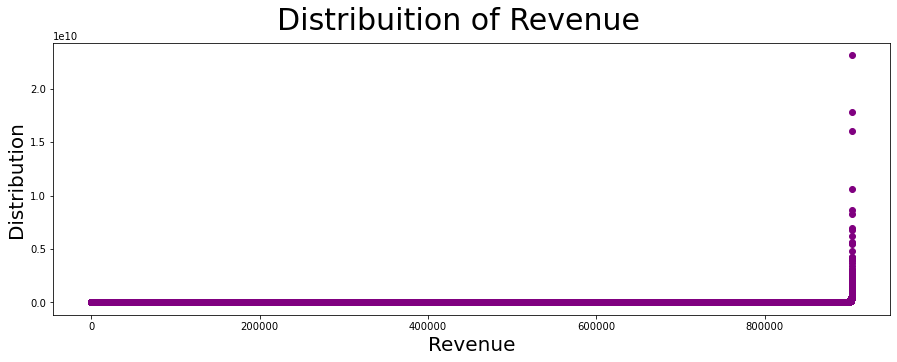

In [232]:
fig = plt.figure(figsize=(15,5))
plt.suptitle('Distribuition of Revenue', fontsize=30)

# ax1 = fig.add_subplot(121)
# _ = sns.distplot(np.log(df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]), bins=40,color='#e56b6f', ax=ax1)
# _ = ax1.set_ylabel('Distribution', fontsize=20)
# _ = ax1.set_xlabel('Transaction Revenue Log', fontsize=20)


#ax2 = fig.add_subplot(122)
plt.scatter(range(ga_data_clean.shape[0]), np.sort(ga_data_clean['totals.transactionRevenue'].values), color='purple')
plt.ylabel('Distribution', fontsize=20)
plt.xlabel('Revenue', fontsize=20)
plt.savefig("RevenueDistribution.png")

According to 80/20 it seems to be true that only a small percentage of customers produce most of the revenue

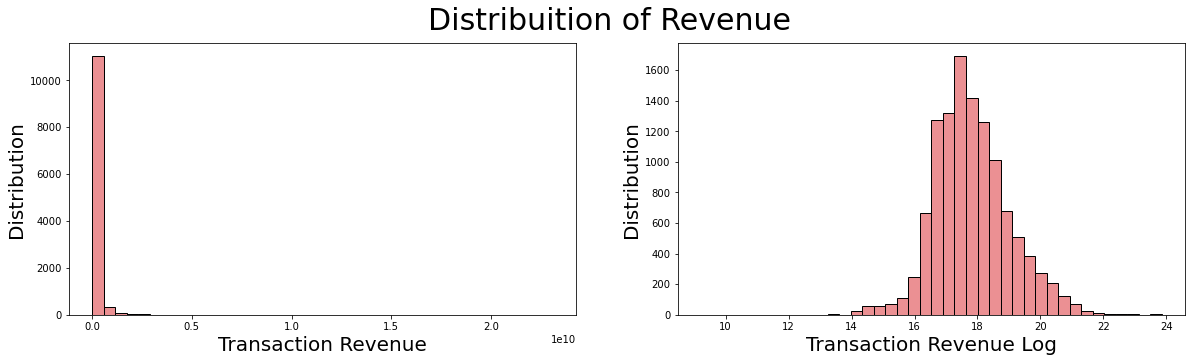

In [233]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Distribuition of Revenue', fontsize=30)

ax1 = fig.add_subplot(121)
sns.histplot(ga_data_clean[ga_data_clean['totals.transactionRevenue'] > 0]["totals.transactionRevenue"], bins=40,color='#e56b6f', ax=ax1)
ax1.set_ylabel('Distribution', fontsize=20)
ax1.set_xlabel('Transaction Revenue', fontsize=20)

ax2 = fig.add_subplot(122)
sns.histplot(np.log(ga_data_clean[ga_data_clean['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]), bins=40,color='#e56b6f', ax=ax2)
ax2.set_ylabel('Distribution', fontsize=20)
ax2.set_xlabel('Transaction Revenue Log', fontsize=20)
plt.savefig("NaturalRevenueDistribution.png")

In [235]:
channel_group_df = ga_data_clean.groupby(by=['channelGrouping']).agg(
                        total_visits = ('totals.visits', sum),
                        mean_revenue = ('totals.transactionRevenue', np.mean))\
                        .reset_index()\
                        .sort_values(by=['mean_revenue', 'total_visits'], ascending=False)
channel_group_df

,channelGrouping,total_visits,mean_revenue
3,Display,6262,1.250997e+07
6,Referral,104838,6.213681e+06
2,Direct,143026,3.040290e+06
5,Paid Search,25326,1.719928e+06
4,Organic Search,381561,8.553823e+05
0,(Other),120,8.325000e+04
1,Affiliates,16403,3.641895e+04
7,Social,226117,2.174335e+04


In [243]:
browser_category_df = ga_data_clean.groupby(by=['device.browser']).agg(
                        total_visits = ('totals.visits', sum),
                        mean_revenue = ('totals.transactionRevenue', np.mean))\
                        .reset_index()\
                        .rename(columns= {'device.browser':'browser'})\
                        .sort_values(by=['mean_revenue', 'total_visits'], ascending=False)
browser_category_df

,browser,total_visits,mean_revenue
16,Firefox,37069,2.409461e+06
11,Chrome,620364,2.229506e+06
15,Edge,10205,6.352739e+05
20,Internet Explorer,19375,4.260929e+05
40,Safari,182245,2.875112e+05
3,Amazon Silk,561,5.345811e+04
36,Opera,5643,3.816233e+04
41,Safari (in-app),6850,2.244818e+04
6,Android Webview,7865,1.460267e+04
37,Opera Mini,6139,0.000000e+00


In [239]:
OS_category_df = ga_data_clean.groupby(by=['device.operatingSystem']).agg(
                        total_visits = ('totals.visits', sum),
                        mean_revenue = ('totals.transactionRevenue', np.mean))\
                        .reset_index()\
                        .rename(columns= {'device.operatingSystem':'OS'})\
                        .sort_values(by=['mean_revenue', 'total_visits'], ascending=False)
OS_category_df

,OS,total_visits,mean_revenue
3,Chrome OS,26337,6.984005e+06
7,Macintosh,253938,3.372381e+06
6,Linux,35034,1.253365e+06
16,Windows,350072,1.134946e+06
1,Android,123892,2.933303e+05
19,iOS,107665,2.058877e+05
17,Windows Phone,1216,2.171053e+04
0,(not set),4695,0.000000e+00
14,Samsung,280,0.000000e+00
2,BlackBerry,218,0.000000e+00


In [248]:
device_category_df = ga_data_clean.groupby(by=['device.deviceCategory']).agg(
                        total_visits = ('totals.visits', sum),
                        mean_revenue = ('totals.transactionRevenue', np.mean))\
                        .reset_index()\
                        .rename(columns= {'device.deviceCategory':'device_category'})\
                        .sort_values(by=['mean_revenue', 'total_visits'], ascending=False)
#device_df.drop(continent_totals_df.loc[continent_totals_df['continent']=='(not set)'].index, inplace=True)
device_category_df

,device_category,total_visits,mean_revenue
0,desktop,664479,2.228609e+06
2,tablet,30449,3.094138e+05
1,mobile,208725,2.385235e+05


In [252]:
medium_category_df = ga_data_clean.groupby(by=['trafficSource.medium']).agg(
                        total_visits = ('totals.visits', sum),
                        mean_revenue = ('totals.transactionRevenue', np.mean))\
                        .reset_index()\
                        .sort_values(by=['mean_revenue', 'total_visits'], ascending=False)
#device_df.drop(continent_totals_df.loc[continent_totals_df['continent']=='(not set)'].index, inplace=True)
medium_category_df

,trafficSource.medium,total_visits,mean_revenue
4,cpm,6262,1.250997e+07
0,(none),143026,3.040290e+06
6,referral,330955,1.983189e+06
3,cpc,25326,1.719928e+06
5,organic,381561,8.553823e+05
1,(not set),120,8.325000e+04
2,affiliate,16403,3.641895e+04


In [ ]:
continent_totals_df = ga_data_clean.groupby(by=['geoNetwork.continent']).agg(
                        total_visits = ('totals.visits', sum),
                        mean_revenue = ('totals.transactionRevenue', np.mean))\
                        .reset_index()\
                        .rename(columns= {'geoNetwork.continent':'continent'})\
                        .sort_values(by=['mean_revenue', 'total_visits'], ascending=False)
continent_totals_df.drop(continent_totals_df.loc[continent_totals_df['continent']=='(not set)'].index, inplace=True)
continent_totals_df

In [ ]:
date time conversion
# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    df['visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df

df_train = date_process(df_train)